#EVALUATING DATA FOR MULTIPLE DATASETS to fit NuScene format for Trajectron++


## Mount the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install necessary requirements for evaluation

In [2]:
%cd /content/drive/My Drive/Colab Notebooks/Trajectron++
!pip install -r requirements.txt

/content/drive/My Drive/Colab Notebooks/Trajectron++


## Process the data

In [3]:
%cd /content/drive/My Drive/Colab Notebooks/Trajectron++/experiments/MAVRIC

/content/drive/My Drive/Colab Notebooks/Trajectron++/experiments/MAVRIC


In [4]:
import sys
import os
import dill
import json
import argparse
import torch
import numpy as np
import pandas as pd
import pdb
sys.path.append("../../trajectron")
from tqdm import tqdm
from model.model_registrar import ModelRegistrar
from model.trajectron import Trajectron
import evaluation
import utils
from scipy.interpolate import RectBivariateSpline
from utils import prediction_output_to_trajectories

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

def batch_statistics(prediction_output_dict,
                             dt,
                             max_hl,
                             ph,
                             node_type_enum,
                             kde=True,
                             obs=False,
                             map=None,
                             prune_ph_to_future=False,
                             best_of=False):
    (prediction_dict,
     _,
     futures_dict) = prediction_output_to_trajectories(prediction_output_dict,
                                                       dt,
                                                       max_hl,
                                                       ph,
                                                       prune_ph_to_future=prune_ph_to_future)
    return prediction_dict, futures_dict

def load_model(model_dir, env, ts=100):
    model_registrar = ModelRegistrar(model_dir, 'cpu')
    model_registrar.load_models(ts)
    with open(os.path.join(model_dir, 'config.json'), 'r') as config_json:
        hyperparams = json.load(config_json)

    trajectron = Trajectron(model_registrar, hyperparams, None, 'cpu')

    trajectron.set_environment(env)
    trajectron.set_annealing_params()
    return trajectron, hyperparams

def print_scene(data):
  with open(data, 'rb') as f:
    env = dill.load(f, encoding='latin1')
  scenes = env.scenes
  for scene in scenes:
    # pdb.set_trace()
    print(scene.name + " " + str(scene))
  

def plot_trajectories(model, checkpoint, data, node_type,prediction_horizon):
  with open(data, 'rb') as f:
    env = dill.load(f, encoding='latin1')

  eval_stg, hyperparams = load_model(model, env, ts=checkpoint)

  if 'override_attention_radius' in hyperparams:
      for attention_radius_override in hyperparams['override_attention_radius']:
          node_type1, node_type2, attention_radius = attention_radius_override.split(' ')
          env.attention_radius[(node_type1, node_type2)] = float(attention_radius)

  scenes = env.scenes

  print("-- Preparing Node Graph")
  for scene in tqdm(scenes):
    # pdb.set_trace()
    scene.calculate_scene_graph(env.attention_radius,
                                  hyperparams['edge_addition_filter'],
                                  hyperparams['edge_removal_filter'])

  for ph in [prediction_horizon]:
    print(f"Prediction Horizon: {ph}")
    max_hl = hyperparams['maximum_history_length']

    with torch.no_grad():
        ############### MOST LIKELY Z ###############
        print("-- Evaluating GMM Z Mode (Most Likely)")
        scene_dict = {}
        scene_gt_dict = {}
        for scene in tqdm(scenes):
            timesteps = np.arange(scene.timesteps)

            predictions = eval_stg.predict(scene,
                                            timesteps,
                                            ph,
                                            num_samples=1,
                                            min_future_timesteps=2,
                                            # min_future_timesteps=8,
                                            z_mode=True,
                                            gmm_mode=True,
                                            full_dist=False)  # This will trigger grid sampling
            # print(scene)
            predict_dict, futures_dict = batch_statistics(predictions,
                                                                       scene.dt,
                                                                       max_hl=max_hl,
                                                                       ph=ph,
                                                                       node_type_enum=env.NodeType,
                                                                       map=None,
                                                                       prune_ph_to_future=False,
                                                                       kde=False)
            # pdb.set_trace()
            # node_dict = {}
            # node_gt_dict = {}
            # for node in scene.nodes:
            #   predict = np.empty((0,2))
            #   # pdb.set_trace()
            #   if (node.type.name == node_type):
            #     for key in predictions.keys():
            #         try:
            #             predict = np.append(predict, predictions[key][node].reshape(predictions[key][node].shape[2],predictions[key][node].shape[3]), axis=0)
            #         except:
            #             pass
            #     node_dict[node.id] = predict
            #     node_gt_dict[node.id] = node.data.data
            # scene_dict[scene.name] = node_dict
            # scene_gt_dict[scene.name] = node_gt_dict
            node_dict = {}
            node_gt_dict = {}
            for node in scene.nodes:
              predict = np.empty((0,2))
              futures = np.empty((0,2))
              if (node.type.name == node_type):
                # pdb.set_trace()
                for key in predict_dict.keys():
                    try:
                        # pdb.set_trace()
                        predict = np.append(predict, predict_dict[key][node].reshape(predict_dict[key][node].shape[2],predict_dict[key][node].shape[3]), axis=0)
                        futures = np.append(futures, futures_dict[key][node], axis=0)
                    except:
                        pass
                node_dict[node.id] = predict
                # node_gt_dict[node.id] = futures
                node_gt_dict[node.id] = node.data.data[:,0:2]
            scene_dict[scene.name] = node_dict
            scene_gt_dict[scene.name] = node_gt_dict

        # pdb.set_trace()
  return scene_dict, scene_gt_dict
        ############### FULL ###############
        # print("-- Evaluating Full")
        # for scene in tqdm(scenes):
        #     timesteps = np.arange(scene.timesteps)
        #     pdb.set_trace()
        #     predictions = eval_stg.predict(scene,
        #                                     timesteps,
        #                                     ph,
        #                                     num_samples=2000,
        #                                     min_future_timesteps=8,
        #                                     z_mode=False,
        #                                     gmm_mode=False,
        #                                     full_dist=False)

        #     if not predictions:
        #         continue

        #     prediction_dict, _, _ = utils.prediction_output_to_trajectories(predictions,
        #                                                                     scene.dt,
        #                                                                     max_hl,
        #                                                                     ph,
        #                                                                     prune_ph_to_future=False)

### NuScenes (Done)
num_samples = 20

In [5]:
print_scene('./data/processed/nuScenes/nuScenes_01_full.pkl')

0 Scene: Duration: 20.0s, Nodes: 1, Map: No.
1 Scene: Duration: 20.0s, Nodes: 18, Map: No.
2 Scene: Duration: 20.0s, Nodes: 20, Map: No.
3 Scene: Duration: 20.0s, Nodes: 11, Map: No.
4 Scene: Duration: 19.5s, Nodes: 8, Map: No.
5 Scene: Duration: 20.0s, Nodes: 4, Map: No.
6 Scene: Duration: 19.5s, Nodes: 25, Map: No.
7 Scene: Duration: 20.0s, Nodes: 25, Map: No.
8 Scene: Duration: 20.0s, Nodes: 10, Map: No.
9 Scene: Duration: 20.0s, Nodes: 9, Map: No.
10 Scene: Duration: 20.0s, Nodes: 2, Map: No.
11 Scene: Duration: 20.0s, Nodes: 4, Map: No.
12 Scene: Duration: 20.0s, Nodes: 16, Map: No.
13 Scene: Duration: 20.0s, Nodes: 6, Map: No.
14 Scene: Duration: 20.0s, Nodes: 14, Map: No.
15 Scene: Duration: 20.0s, Nodes: 45, Map: No.
16 Scene: Duration: 20.0s, Nodes: 51, Map: No.
17 Scene: Duration: 20.0s, Nodes: 28, Map: No.
18 Scene: Duration: 20.0s, Nodes: 35, Map: No.
19 Scene: Duration: 19.5s, Nodes: 12, Map: No.
20 Scene: Duration: 20.0s, Nodes: 18, Map: No.
21 Scene: Duration: 20.0s, Nod

In [6]:
data_nu_2, data_gt_nu_2 = plot_trajectories('models/int_ee', 12, './data/processed/nuScenes/nuScenes_01_full.pkl', 'VEHICLE', 2)


Loading from models/int_ee/model_registrar-12.pt
Loaded!



 19%|█▉        | 16/85 [00:00<00:00, 133.67it/s]

-- Preparing Node Graph


  0%|          | 0/85 [00:00<?, ?it/s]

Prediction Horizon: 2
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 85/85 [00:58<00:00,  1.46it/s]


In [7]:
data_nu_2.keys()
for key in data_nu_2.keys():
  print(key + ' ' + str(data_nu_2[key].keys()))

0 dict_keys(['ego'])
1 dict_keys(['ego', '14', '13', '12', '11', '15', '16', '17', '18', '19', '20', '21', '22', '23', '25', '26', '27', '28'])
2 dict_keys(['15', '16', '17', '18', '19', '21', '23', '24', 'ego', '22', '20', '25', '26', '27', '28', '29', '30', '31', '33', '34'])
3 dict_keys(['ego'])
4 dict_keys(['ego', '11', '10', '8', '9', '12', '13', '14'])
5 dict_keys(['ego'])
6 dict_keys(['ego'])
7 dict_keys(['ego'])
8 dict_keys(['ego'])
9 dict_keys(['ego', '5', '6', '7', '8', '9', '10', '11', '12'])
10 dict_keys(['ego'])
11 dict_keys(['ego', '1', '2', '3'])
12 dict_keys(['ego', '1', '2', '3', '4', '5', '6', '9', '8', '7', '10', '11', '12', '13', '14', '15'])
13 dict_keys(['0', 'ego', '1', '2', '3', '4'])
14 dict_keys(['0', '1', '2', 'ego', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'])
15 dict_keys(['ego'])
16 dict_keys(['ego'])
17 dict_keys(['ego'])
18 dict_keys(['ego'])
19 dict_keys(['ego'])
20 dict_keys(['ego', '18', '17', '16', '15', '14', '19', '20', '21', '22', '23', 

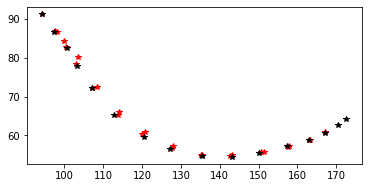

(26,)
(16,)


In [8]:
import matplotlib.pyplot as plt
data = data_nu_2['1']['14']
data_gt = data_gt_nu_2['1']['14']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()
print(data[:,0].shape)
print(data_gt[:,0].shape)

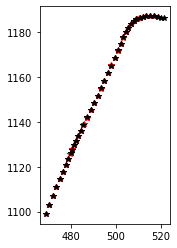

ego(74, 2)
ego(40, 2)


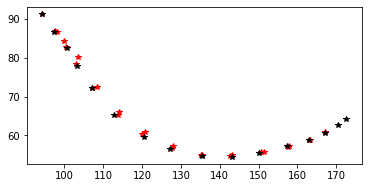

14(26, 2)
14(16, 2)


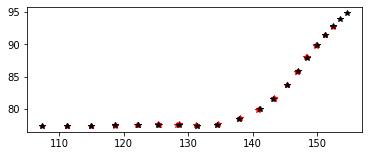

13(34, 2)
13(20, 2)


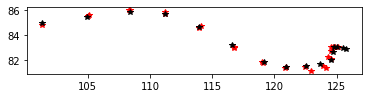

12(26, 2)
12(16, 2)


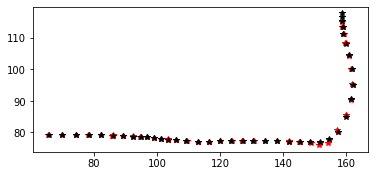

11(74, 2)
11(40, 2)


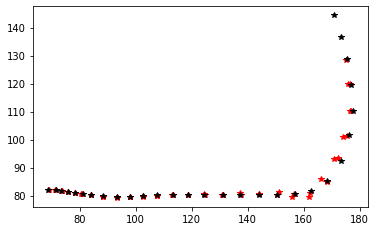

15(52, 2)
15(29, 2)


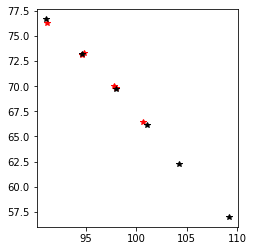

16(6, 2)
16(6, 2)


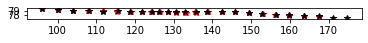

17(44, 2)
17(25, 2)


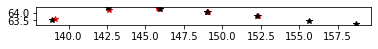

18(8, 2)
18(7, 2)


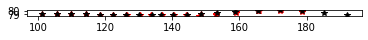

19(34, 2)
19(20, 2)


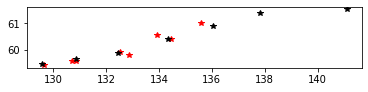

20(8, 2)
20(7, 2)


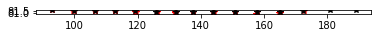

21(24, 2)
21(15, 2)


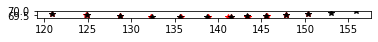

22(20, 2)
22(13, 2)


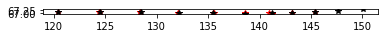

23(16, 2)
23(11, 2)


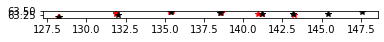

25(10, 2)
25(8, 2)


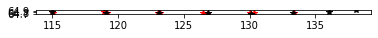

26(10, 2)
26(8, 2)


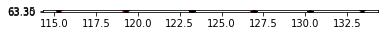

27(6, 2)
27(6, 2)


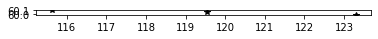

28(0, 2)
28(3, 2)


In [9]:
import matplotlib.pyplot as plt
scene = '1'
for key in data_nu_2[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_nu_2[scene][key]
  data_gt = data_gt_nu_2[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(str(key) + str(data.shape))
  print(str(key) + str(data_gt.shape))


In [10]:
data_nu_4, data_gt_nu_4 = plot_trajectories('models/int_ee', 12, './data/processed/nuScenes/nuScenes_01_full.pkl', 'VEHICLE', 4)

 19%|█▉        | 16/85 [00:00<00:00, 128.98it/s]


Loading from models/int_ee/model_registrar-12.pt
Loaded!

-- Preparing Node Graph


  0%|          | 0/85 [00:00<?, ?it/s]

Prediction Horizon: 4
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 85/85 [00:59<00:00,  1.43it/s]


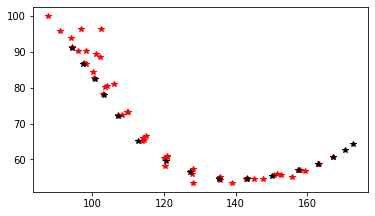

(52,)
(16,)


In [11]:
import matplotlib.pyplot as plt
data = data_nu_4['1']['14']
data_gt = data_gt_nu_4['1']['14']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()
print(data[:,0].shape)
print(data_gt[:,0].shape)

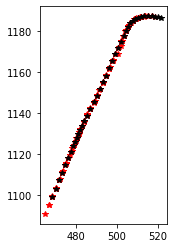

ego(148, 2)
ego(40, 2)


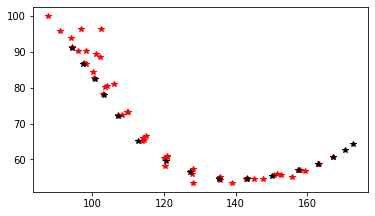

14(52, 2)
14(16, 2)


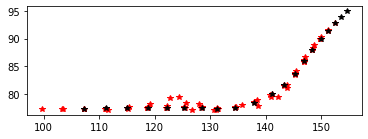

13(68, 2)
13(20, 2)


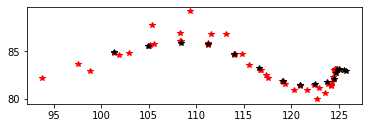

12(52, 2)
12(16, 2)


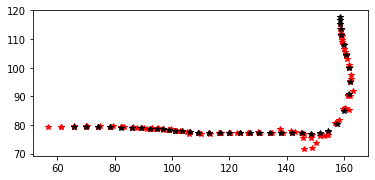

11(148, 2)
11(40, 2)


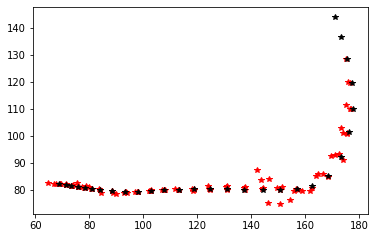

15(104, 2)
15(29, 2)


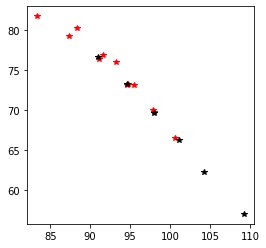

16(12, 2)
16(6, 2)


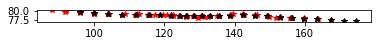

17(88, 2)
17(25, 2)


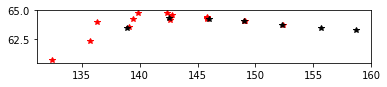

18(16, 2)
18(7, 2)


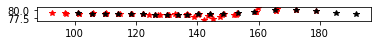

19(68, 2)
19(20, 2)


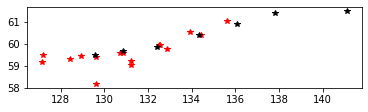

20(16, 2)
20(7, 2)


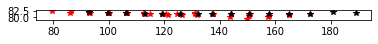

21(48, 2)
21(15, 2)


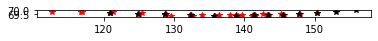

22(40, 2)
22(13, 2)


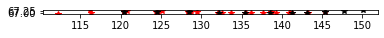

23(32, 2)
23(11, 2)


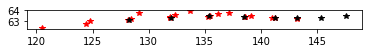

25(20, 2)
25(8, 2)


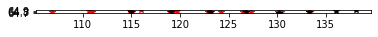

26(20, 2)
26(8, 2)


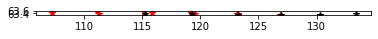

27(12, 2)
27(6, 2)


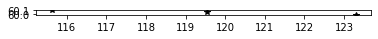

28(0, 2)
28(3, 2)


In [12]:
import matplotlib.pyplot as plt
scene = '1'
for key in data_nu_4[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_nu_4[scene][key]
  data_gt = data_gt_nu_4[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(str(key) + str(data.shape))
  print(str(key) + str(data_gt.shape))


In [13]:
data_nu_6, data_gt_nu_6 = plot_trajectories('models/int_ee', 12, './data/processed/nuScenes/nuScenes_01_full.pkl', 'VEHICLE', 6)

 19%|█▉        | 16/85 [00:00<00:00, 129.68it/s]


Loading from models/int_ee/model_registrar-12.pt
Loaded!

-- Preparing Node Graph


  0%|          | 0/85 [00:00<?, ?it/s]

Prediction Horizon: 6
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 85/85 [01:00<00:00,  1.40it/s]


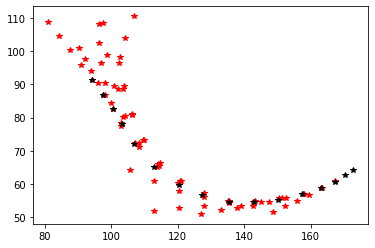

(78,)
(16,)


In [14]:
import matplotlib.pyplot as plt
data = data_nu_6['1']['14']
data_gt = data_gt_nu_6['1']['14']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()
print(data[:,0].shape)
print(data_gt[:,0].shape)

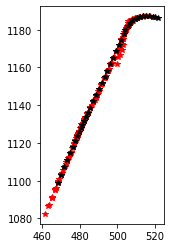

ego(222, 2)
ego(40, 2)


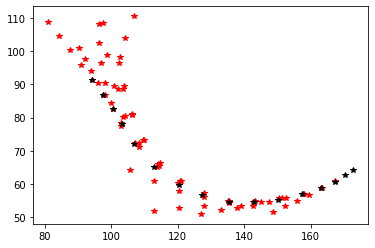

14(78, 2)
14(16, 2)


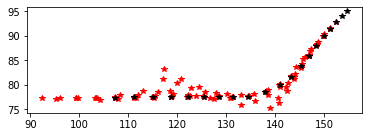

13(102, 2)
13(20, 2)


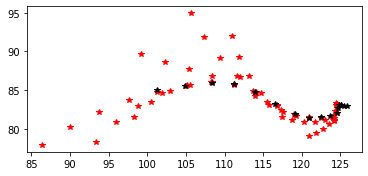

12(78, 2)
12(16, 2)


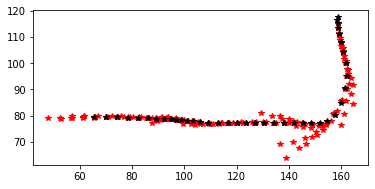

11(222, 2)
11(40, 2)


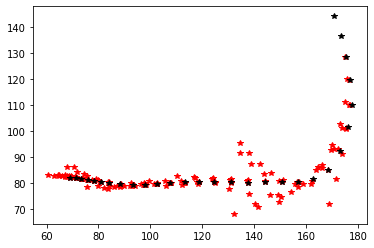

15(156, 2)
15(29, 2)


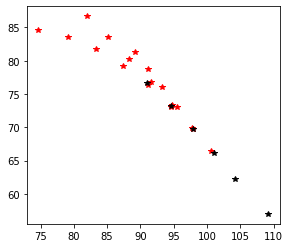

16(18, 2)
16(6, 2)


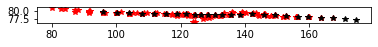

17(132, 2)
17(25, 2)


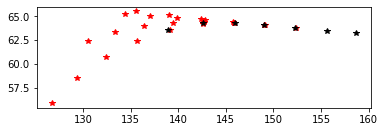

18(24, 2)
18(7, 2)


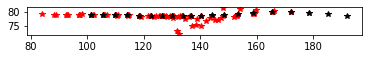

19(102, 2)
19(20, 2)


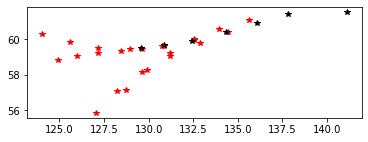

20(24, 2)
20(7, 2)


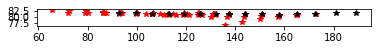

21(72, 2)
21(15, 2)


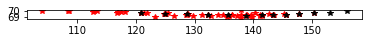

22(60, 2)
22(13, 2)


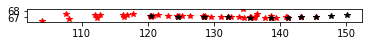

23(48, 2)
23(11, 2)


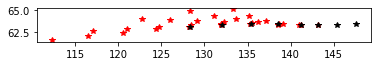

25(30, 2)
25(8, 2)


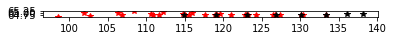

26(30, 2)
26(8, 2)


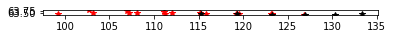

27(18, 2)
27(6, 2)


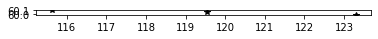

28(0, 2)
28(3, 2)


In [15]:
import matplotlib.pyplot as plt
scene = '1'
for key in data_nu_6[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_nu_6[scene][key]
  data_gt = data_gt_nu_6[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(str(key) + str(data.shape))
  print(str(key) + str(data_gt.shape))


### Lyft (Done)

In [16]:
print_scene('./data/processed/Lyft/Lyft_1_full.pkl')

1513 Scene: Duration: 25.200000000000003s, Nodes: 44, Map: No.
1514 Scene: Duration: 25.200000000000003s, Nodes: 25, Map: No.
1515 Scene: Duration: 25.200000000000003s, Nodes: 73, Map: No.
1516 Scene: Duration: 25.200000000000003s, Nodes: 53, Map: No.
1517 Scene: Duration: 25.200000000000003s, Nodes: 20, Map: No.
1518 Scene: Duration: 25.200000000000003s, Nodes: 4, Map: No.
1519 Scene: Duration: 25.200000000000003s, Nodes: 84, Map: No.
1520 Scene: Duration: 25.200000000000003s, Nodes: 42, Map: No.
1521 Scene: Duration: 25.200000000000003s, Nodes: 8, Map: No.
1522 Scene: Duration: 25.200000000000003s, Nodes: 36, Map: No.
1523 Scene: Duration: 25.200000000000003s, Nodes: 22, Map: No.
1524 Scene: Duration: 25.200000000000003s, Nodes: 14, Map: No.
1525 Scene: Duration: 25.200000000000003s, Nodes: 41, Map: No.
1526 Scene: Duration: 25.200000000000003s, Nodes: 5, Map: No.
1527 Scene: Duration: 25.200000000000003s, Nodes: 43, Map: No.
1528 Scene: Duration: 25.200000000000003s, Nodes: 22, Map:

In [17]:
data_lyft_2, data_gt_lyft_2 = plot_trajectories('models/int_ee', 12, './data/processed/Lyft/Lyft_1_full.pkl', 'VEHICLE', 2)

  0%|          | 0/90 [00:00<?, ?it/s]


Loading from models/int_ee/model_registrar-12.pt
Loaded!

-- Preparing Node Graph


  0%|          | 0/90 [00:00<?, ?it/s]

Prediction Horizon: 2
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 90/90 [02:19<00:00,  1.55s/it]


In [18]:
data_lyft_2.keys()
for key in data_lyft_2.keys():
  print(key + ' ' + str(data_lyft_2[key].keys()))

1513 dict_keys(['33', '34', '35', '38', '39', '45', '48', '52', '58', 'ego', '30', '29', '10', '12', '27', '26', '18', '16', '72', '82', '84', '86', '89', '94', '93', '95', '98', '99', '100', '101', '102', '104', '105', '107', '108', '109', '110', '112', '114', '113', '117', '119', '120', '121'])
1514 dict_keys(['ego', '26', '24', '23', '22', '17', '15', '21', '12', '11', '30', '34', '32', '36', '40', '41', '43', '54', '67', '69', '79', '80', '81', '83', '84'])
1515 dict_keys(['22', '23', '27', '32', '34', '35', '38', '39', '40', 'ego', '20', '19', '4', '5', '7', '8', '9', '16', '15', '14', '17', '12', '11', '54', '58', '59', '60', '61', '62', '64', '69', '71', '75', '76', '79', '85', '86', '87', '90', '89', '94', '95', '97', '98', '104', '105', '114', '115', '118', '122', '128', '129', '132', '135', '134', '137', '139', '145', '150', '152', '154', '155', '157', '159', '161', '162', '163', '165', '167', '168', '169', '170', '171'])
1516 dict_keys(['22', '26', '27', '28', '31', '32', '3

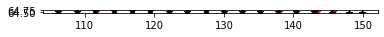

(30,)
(18,)


In [19]:
import matplotlib.pyplot as plt
data = data_lyft_2['1546']['29']
data_gt = data_gt_lyft_2['1546']['29']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()
print(data[:,0].shape)
print(data_gt[:,0].shape)

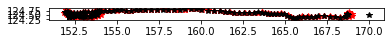

(246, 2)
(126, 2)


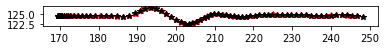

(154, 2)
(80, 2)


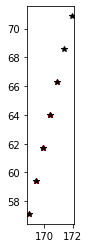

(8, 2)
(7, 2)


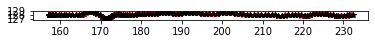

(246, 2)
(126, 2)


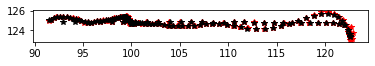

(246, 2)
(126, 2)


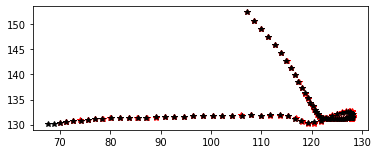

(170, 2)
(88, 2)


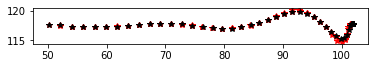

(124, 2)
(65, 2)


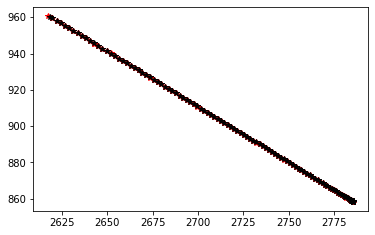

(246, 2)
(126, 2)


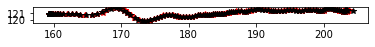

(246, 2)
(126, 2)


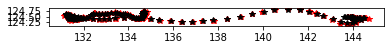

(246, 2)
(126, 2)


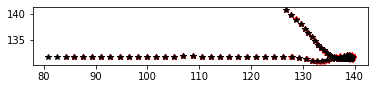

(142, 2)
(74, 2)


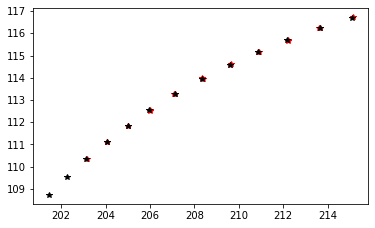

(20, 2)
(13, 2)


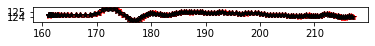

(246, 2)
(126, 2)


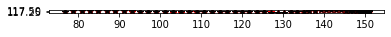

(146, 2)
(76, 2)


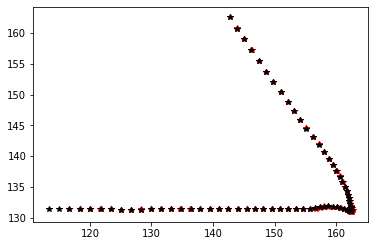

(138, 2)
(72, 2)


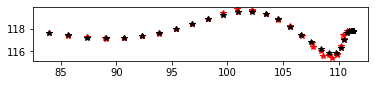

(98, 2)
(52, 2)


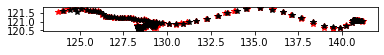

(246, 2)
(126, 2)


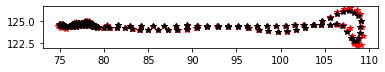

(202, 2)
(104, 2)


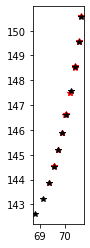

(16, 2)
(11, 2)


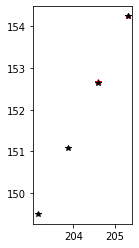

(2, 2)
(4, 2)


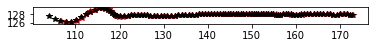

(190, 2)
(98, 2)


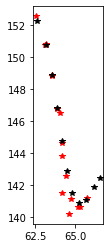

(16, 2)
(11, 2)


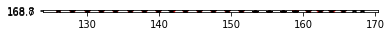

(42, 2)
(24, 2)


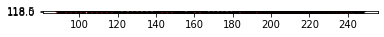

(134, 2)
(70, 2)


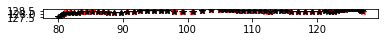

(124, 2)
(65, 2)


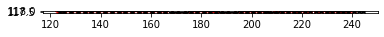

(96, 2)
(51, 2)


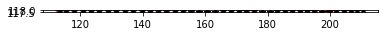

(74, 2)
(40, 2)


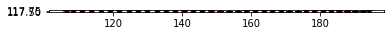

(66, 2)
(36, 2)


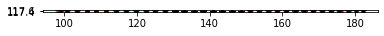

(62, 2)
(34, 2)


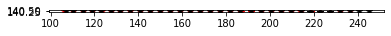

(58, 2)
(32, 2)


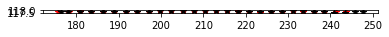

(52, 2)
(29, 2)


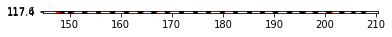

(42, 2)
(24, 2)


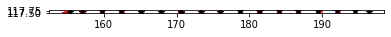

(28, 2)
(17, 2)


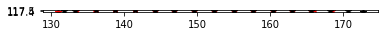

(28, 2)
(17, 2)


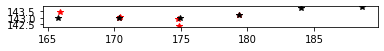

(6, 2)
(6, 2)


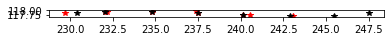

(10, 2)
(8, 2)


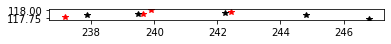

(4, 2)
(5, 2)


In [20]:
import matplotlib.pyplot as plt
scene = '1542'
for key in data_lyft_2[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_lyft_2[scene][key]
  data_gt = data_gt_lyft_2[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(data.shape)
  print(data_gt.shape)


In [21]:
data_lyft_4, data_gt_lyft_4 = plot_trajectories('models/int_ee', 12, './data/processed/Lyft/Lyft_1_full.pkl', 'VEHICLE', 4)

  0%|          | 0/90 [00:00<?, ?it/s]


Loading from models/int_ee/model_registrar-12.pt
Loaded!

-- Preparing Node Graph


  0%|          | 0/90 [00:00<?, ?it/s]

Prediction Horizon: 4
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 90/90 [02:20<00:00,  1.56s/it]


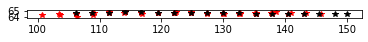

(60,)
(18,)


In [22]:
import matplotlib.pyplot as plt
data = data_lyft_4['1546']['29']
data_gt = data_gt_lyft_4['1546']['29']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()
print(data[:,0].shape)
print(data_gt[:,0].shape)

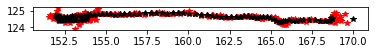

(492, 2)
(126, 2)


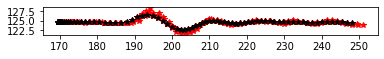

(308, 2)
(80, 2)


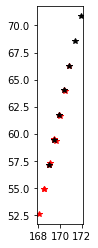

(16, 2)
(7, 2)


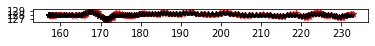

(492, 2)
(126, 2)


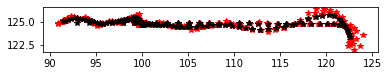

(492, 2)
(126, 2)


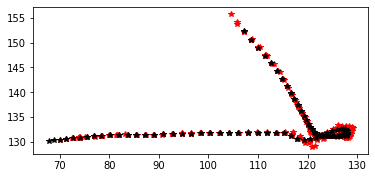

(340, 2)
(88, 2)


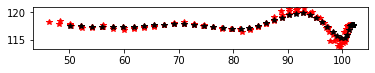

(248, 2)
(65, 2)


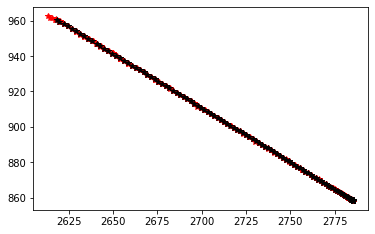

(492, 2)
(126, 2)


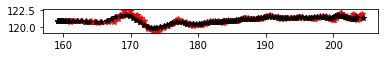

(492, 2)
(126, 2)


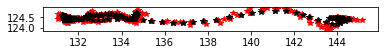

(492, 2)
(126, 2)


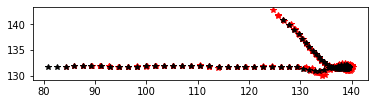

(284, 2)
(74, 2)


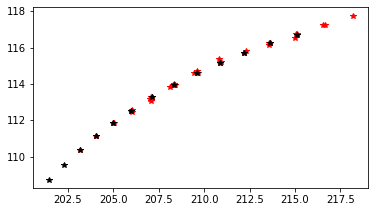

(40, 2)
(13, 2)


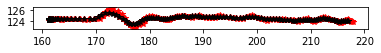

(492, 2)
(126, 2)


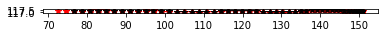

(292, 2)
(76, 2)


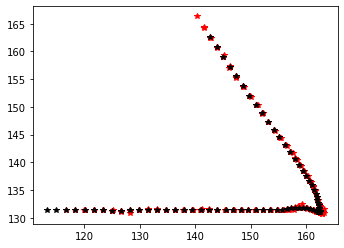

(276, 2)
(72, 2)


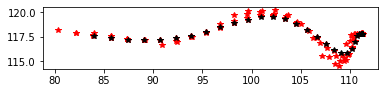

(196, 2)
(52, 2)


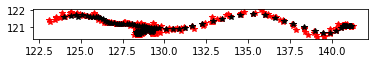

(492, 2)
(126, 2)


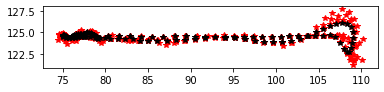

(404, 2)
(104, 2)


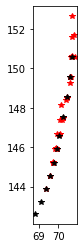

(32, 2)
(11, 2)


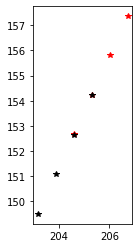

(4, 2)
(4, 2)


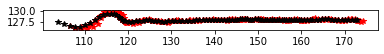

(380, 2)
(98, 2)


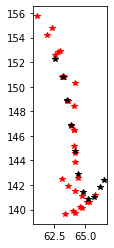

(32, 2)
(11, 2)


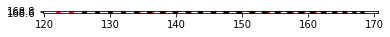

(84, 2)
(24, 2)


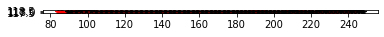

(268, 2)
(70, 2)


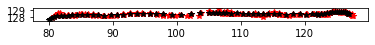

(248, 2)
(65, 2)


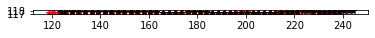

(192, 2)
(51, 2)


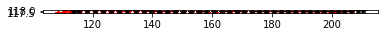

(148, 2)
(40, 2)


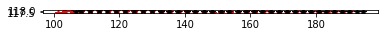

(132, 2)
(36, 2)


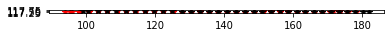

(124, 2)
(34, 2)


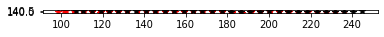

(116, 2)
(32, 2)


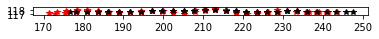

(104, 2)
(29, 2)


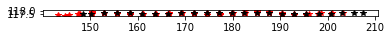

(84, 2)
(24, 2)


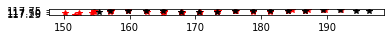

(56, 2)
(17, 2)


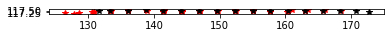

(56, 2)
(17, 2)


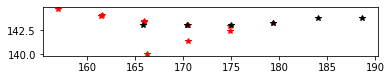

(12, 2)
(6, 2)


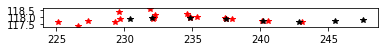

(20, 2)
(8, 2)


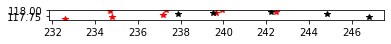

(8, 2)
(5, 2)


In [23]:
import matplotlib.pyplot as plt
scene = '1542'
for key in data_lyft_4[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_lyft_4[scene][key]
  data_gt = data_gt_lyft_4[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(data.shape)
  print(data_gt.shape)


In [24]:
data_lyft_6, data_gt_lyft_6 = plot_trajectories('models/int_ee', 12, './data/processed/Lyft/Lyft_1_full.pkl', 'VEHICLE', 6)

  0%|          | 0/90 [00:00<?, ?it/s]


Loading from models/int_ee/model_registrar-12.pt
Loaded!

-- Preparing Node Graph


  0%|          | 0/90 [00:00<?, ?it/s]

Prediction Horizon: 6
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 90/90 [02:22<00:00,  1.58s/it]


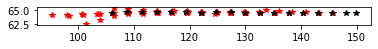

(90,)
(18,)


In [25]:
import matplotlib.pyplot as plt
data = data_lyft_6['1546']['29']
data_gt = data_gt_lyft_6['1546']['29']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()
print(data[:,0].shape)
print(data_gt[:,0].shape)

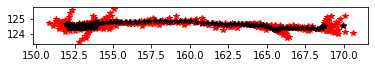

(738, 2)
(126, 2)


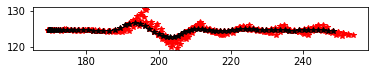

(462, 2)
(80, 2)


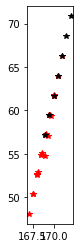

(24, 2)
(7, 2)


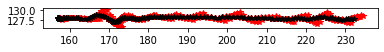

(738, 2)
(126, 2)


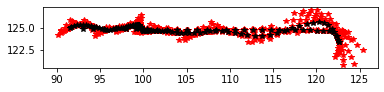

(738, 2)
(126, 2)


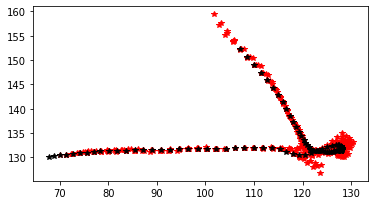

(510, 2)
(88, 2)


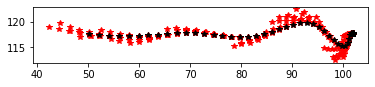

(372, 2)
(65, 2)


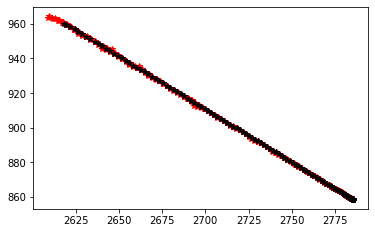

(738, 2)
(126, 2)


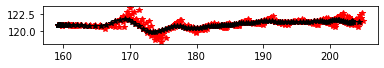

(738, 2)
(126, 2)


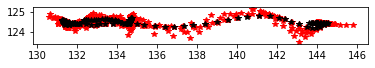

(738, 2)
(126, 2)


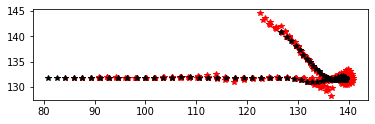

(426, 2)
(74, 2)


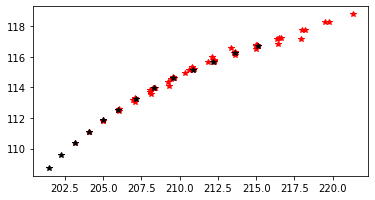

(60, 2)
(13, 2)


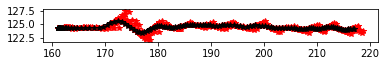

(738, 2)
(126, 2)


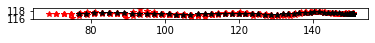

(438, 2)
(76, 2)


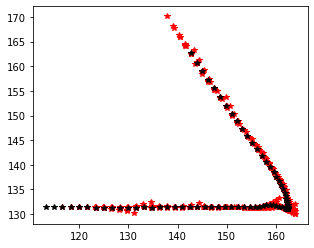

(414, 2)
(72, 2)


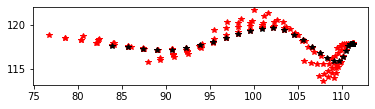

(294, 2)
(52, 2)


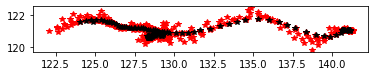

(738, 2)
(126, 2)


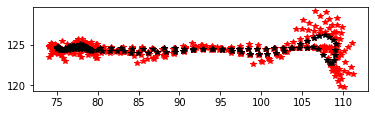

(606, 2)
(104, 2)


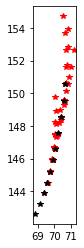

(48, 2)
(11, 2)


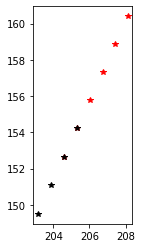

(6, 2)
(4, 2)


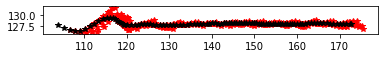

(570, 2)
(98, 2)


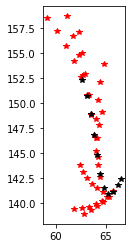

(48, 2)
(11, 2)


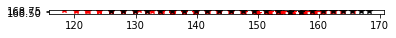

(126, 2)
(24, 2)


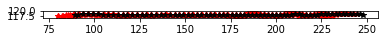

(402, 2)
(70, 2)


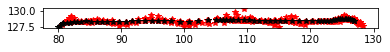

(372, 2)
(65, 2)


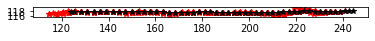

(288, 2)
(51, 2)


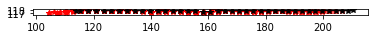

(222, 2)
(40, 2)


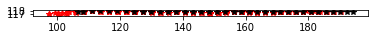

(198, 2)
(36, 2)


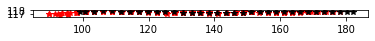

(186, 2)
(34, 2)


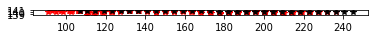

(174, 2)
(32, 2)


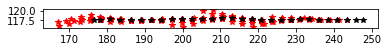

(156, 2)
(29, 2)


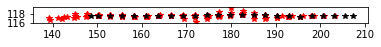

(126, 2)
(24, 2)


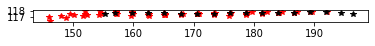

(84, 2)
(17, 2)


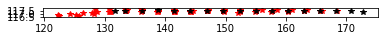

(84, 2)
(17, 2)


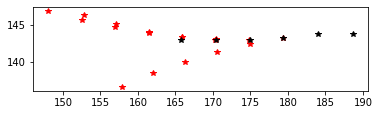

(18, 2)
(6, 2)


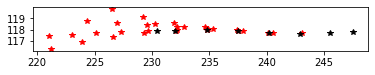

(30, 2)
(8, 2)


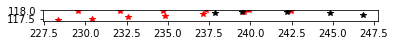

(12, 2)
(5, 2)


In [26]:
import matplotlib.pyplot as plt
scene = '1542'
for key in data_lyft_6[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_lyft_6[scene][key]
  data_gt = data_gt_lyft_6[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(data.shape)
  print(data_gt.shape)


### Argo (Done)

In [27]:
print_scene('./data/processed/Argoverse/Argoverse_1_full.pkl')

1448 Scene: Duration: 31.400000000000002s, Nodes: 25, Map: No.
1449 Scene: Duration: 60.0s, Nodes: 13, Map: No.
1450 Scene: Duration: 31.200000000000003s, Nodes: 22, Map: No.
1451 Scene: Duration: 57.800000000000004s, Nodes: 27, Map: No.
1452 Scene: Duration: 31.400000000000002s, Nodes: 20, Map: No.
1453 Scene: Duration: 29.400000000000002s, Nodes: 10, Map: No.
1454 Scene: Duration: 31.400000000000002s, Nodes: 30, Map: No.
1455 Scene: Duration: 29.200000000000003s, Nodes: 16, Map: No.
1456 Scene: Duration: 31.200000000000003s, Nodes: 17, Map: No.
1457 Scene: Duration: 31.0s, Nodes: 27, Map: No.
1458 Scene: Duration: 30.8s, Nodes: 11, Map: No.
1459 Scene: Duration: 58.6s, Nodes: 29, Map: No.
1460 Scene: Duration: 58.400000000000006s, Nodes: 10, Map: No.
1461 Scene: Duration: 31.400000000000002s, Nodes: 36, Map: No.
1462 Scene: Duration: 59.800000000000004s, Nodes: 11, Map: No.
1463 Scene: Duration: 31.200000000000003s, Nodes: 19, Map: No.
1464 Scene: Duration: 31.200000000000003s, Nodes

In [28]:
data_argo_2, data_gt_argo_2 = plot_trajectories('models/int_ee', 12, './data/processed/Argoverse/Argoverse_1_full.pkl', 'VEHICLE', 2)

 15%|█▌        | 3/20 [00:00<00:00, 28.46it/s]


Loading from models/int_ee/model_registrar-12.pt
Loaded!

-- Preparing Node Graph


  0%|          | 0/20 [00:00<?, ?it/s]

Prediction Horizon: 2
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 20/20 [00:42<00:00,  2.11s/it]


In [29]:
data_argo_2.keys()
for key in data_argo_2.keys():
  print(key + ' ' + str(data_argo_2[key].keys()))

1448 dict_keys(['ego'])
1449 dict_keys(['ego', '17', '16', '15', '12', '11', '13', '22', '24', '26', '39', '53', '59'])
1450 dict_keys(['35', '36', '37', '38', '39', '31', '42', '44', '45', '46', '47', '48', '50', 'ego', '43', '40', '55', '75', '82', '92', '99', '102'])
1451 dict_keys(['ego', '22', '18', '17', '12', '5', '6', '8', '9', '10', '11', '7', '23', '24', '25', '26', '30', '35', '33', '34', '37', '38', '45', '53', '54', '55', '56'])
1452 dict_keys(['ego', '23', '21', '18', '16', '22', '14', '15', '2', '1', '9', '10', '11', '12', '13', '37', '40', '41', '47', '48'])
1453 dict_keys(['25', '27', '36', 'ego', '33', '18', '44', '51', '88', '95'])
1454 dict_keys(['27', '28', '36', '26', '40', '44', 'ego', '39', '25', '23', '24', '18', '19', '20', '21', '46', '68', '70', '72', '73', '74', '75', '77', '76', '78', '79', '82', '83', '84', '85'])
1455 dict_keys(['19', '27', 'ego', '30', '33', '35', '37', '38', '39', '43', '45', '51', '55', '60', '61', '62'])
1456 dict_keys(['20', '21', '

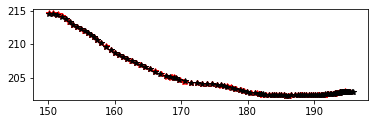

In [30]:
import matplotlib.pyplot as plt
data = data_argo_2['1449']['17']
data_gt = data_gt_argo_2['1449']['17']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()

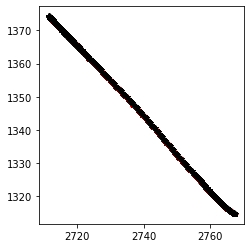

ego(572, 2)
ego(289, 2)


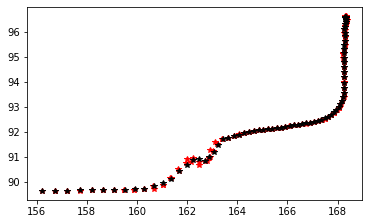

22(150, 2)
22(78, 2)


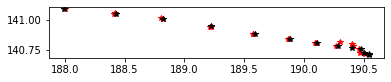

18(20, 2)
18(13, 2)


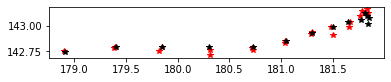

17(22, 2)
17(14, 2)


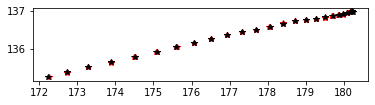

12(46, 2)
12(26, 2)


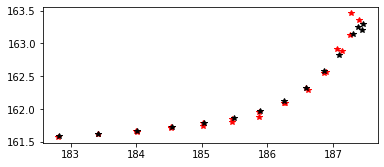

5(24, 2)
5(15, 2)


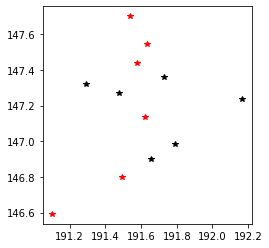

6(6, 2)
6(6, 2)


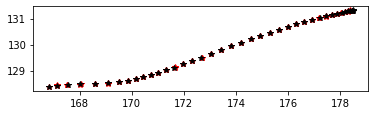

8(76, 2)
8(41, 2)


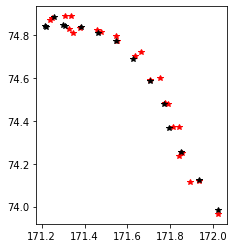

9(24, 2)
9(15, 2)


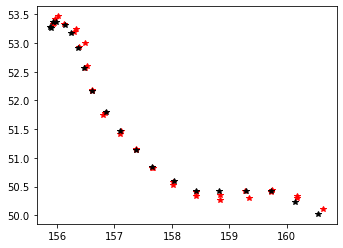

10(34, 2)
10(20, 2)


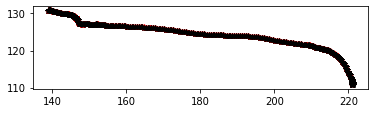

11(572, 2)
11(289, 2)


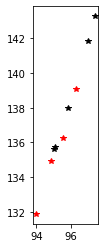

7(4, 2)
7(5, 2)


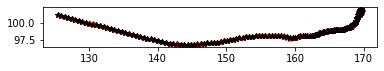

23(272, 2)
23(139, 2)


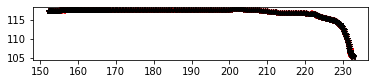

24(562, 2)
24(284, 2)


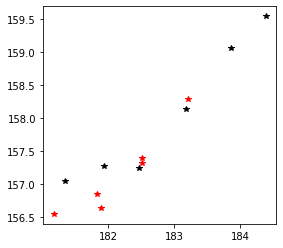

25(6, 2)
25(6, 2)


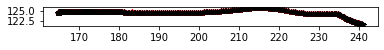

26(498, 2)
26(252, 2)


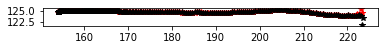

30(444, 2)
30(225, 2)


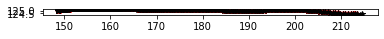

35(422, 2)
35(214, 2)


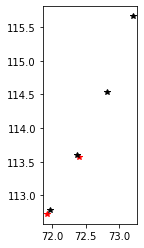

33(2, 2)
33(4, 2)


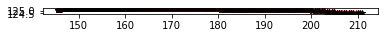

34(422, 2)
34(214, 2)


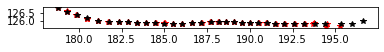

37(60, 2)
37(33, 2)


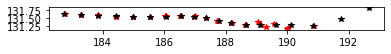

38(32, 2)
38(19, 2)


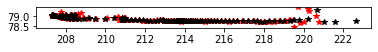

45(196, 2)
45(101, 2)


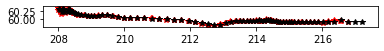

53(158, 2)
53(82, 2)


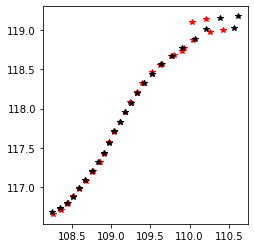

54(44, 2)
54(25, 2)


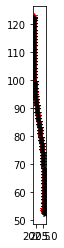

55(126, 2)
55(66, 2)


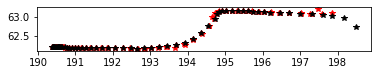

56(116, 2)
56(61, 2)


In [31]:
import matplotlib.pyplot as plt
scene = '1451'
for key in data_argo_2[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_argo_2[scene][key]
  data_gt = data_gt_argo_2[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(str(key) + str(data.shape))
  print(str(key) + str(data_gt.shape))


In [32]:
data_argo_4, data_gt_argo_4 = plot_trajectories('models/int_ee', 12, './data/processed/Argoverse/Argoverse_1_full.pkl', 'VEHICLE', 4)

 15%|█▌        | 3/20 [00:00<00:00, 26.10it/s]


Loading from models/int_ee/model_registrar-12.pt
Loaded!

-- Preparing Node Graph


  0%|          | 0/20 [00:00<?, ?it/s]

Prediction Horizon: 4
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 20/20 [00:42<00:00,  2.13s/it]


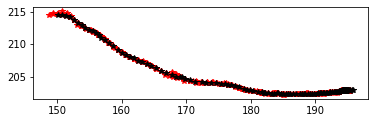

In [33]:
import matplotlib.pyplot as plt
data = data_argo_4['1449']['17']
data_gt = data_gt_argo_4['1449']['17']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()

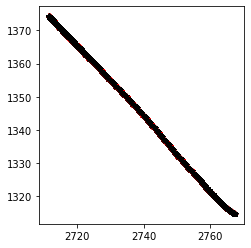

ego(1144, 2)
ego(289, 2)


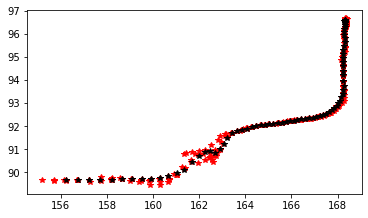

22(300, 2)
22(78, 2)


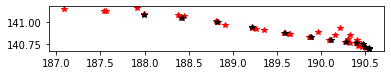

18(40, 2)
18(13, 2)


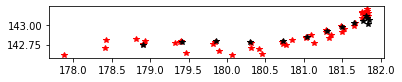

17(44, 2)
17(14, 2)


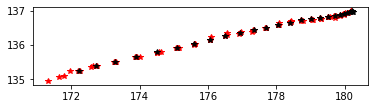

12(92, 2)
12(26, 2)


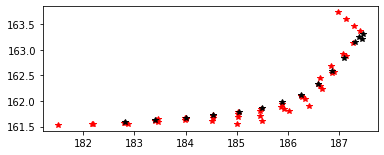

5(48, 2)
5(15, 2)


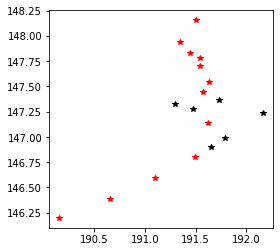

6(12, 2)
6(6, 2)


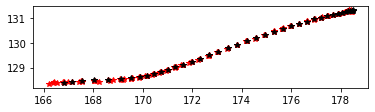

8(152, 2)
8(41, 2)


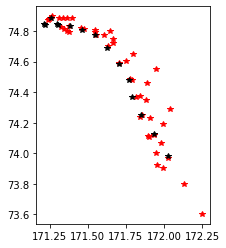

9(48, 2)
9(15, 2)


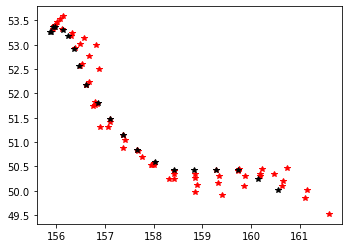

10(68, 2)
10(20, 2)


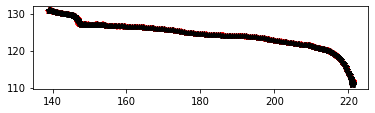

11(1144, 2)
11(289, 2)


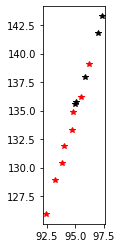

7(8, 2)
7(5, 2)


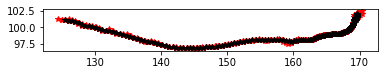

23(544, 2)
23(139, 2)


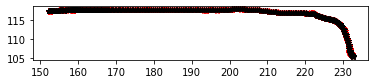

24(1124, 2)
24(284, 2)


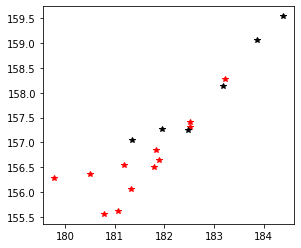

25(12, 2)
25(6, 2)


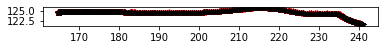

26(996, 2)
26(252, 2)


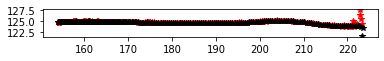

30(888, 2)
30(225, 2)


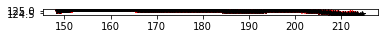

35(844, 2)
35(214, 2)


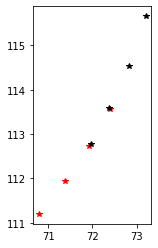

33(4, 2)
33(4, 2)


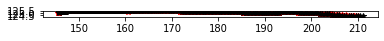

34(844, 2)
34(214, 2)


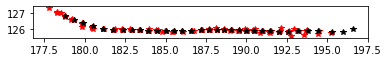

37(120, 2)
37(33, 2)


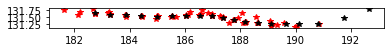

38(64, 2)
38(19, 2)


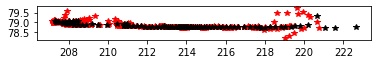

45(392, 2)
45(101, 2)


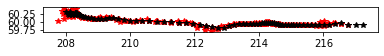

53(316, 2)
53(82, 2)


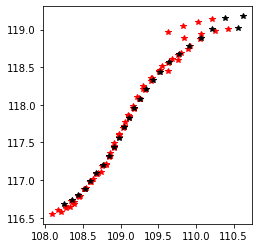

54(88, 2)
54(25, 2)


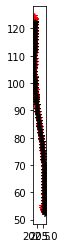

55(252, 2)
55(66, 2)


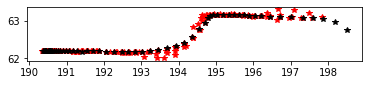

56(232, 2)
56(61, 2)


In [34]:
import matplotlib.pyplot as plt
scene = '1451'
for key in data_argo_4[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_argo_4[scene][key]
  data_gt = data_gt_argo_4[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(str(key) + str(data.shape))
  print(str(key) + str(data_gt.shape))


In [35]:
data_argo_6, data_gt_argo_6 = plot_trajectories('models/int_ee', 12, './data/processed/Argoverse/Argoverse_1_full.pkl', 'VEHICLE', 6)

 15%|█▌        | 3/20 [00:00<00:00, 28.33it/s]


Loading from models/int_ee/model_registrar-12.pt
Loaded!

-- Preparing Node Graph


  0%|          | 0/20 [00:00<?, ?it/s]

Prediction Horizon: 6
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 20/20 [00:43<00:00,  2.15s/it]


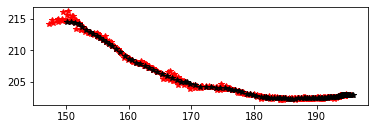

In [36]:
import matplotlib.pyplot as plt
data = data_argo_6['1449']['17']
data_gt = data_gt_argo_6['1449']['17']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()

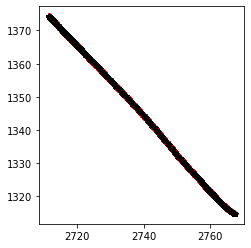

ego(1716, 2)
ego(289, 2)


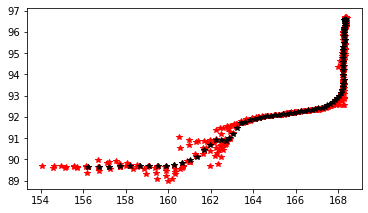

22(450, 2)
22(78, 2)


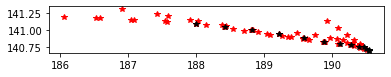

18(60, 2)
18(13, 2)


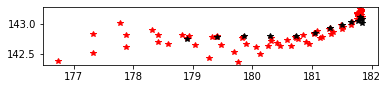

17(66, 2)
17(14, 2)


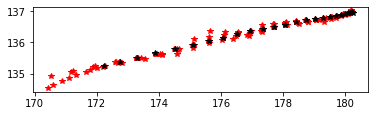

12(138, 2)
12(26, 2)


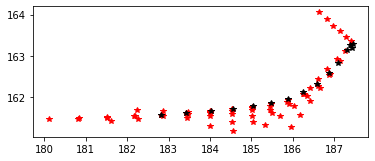

5(72, 2)
5(15, 2)


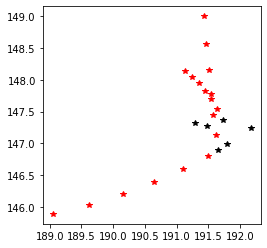

6(18, 2)
6(6, 2)


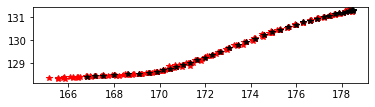

8(228, 2)
8(41, 2)


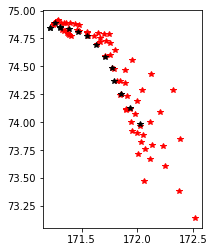

9(72, 2)
9(15, 2)


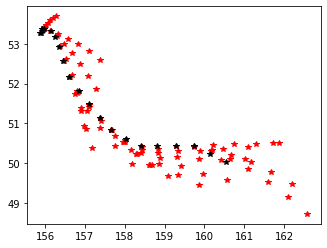

10(102, 2)
10(20, 2)


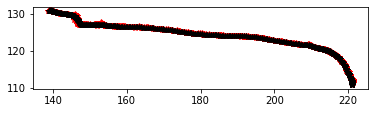

11(1716, 2)
11(289, 2)


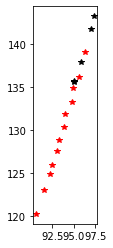

7(12, 2)
7(5, 2)


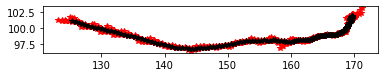

23(816, 2)
23(139, 2)


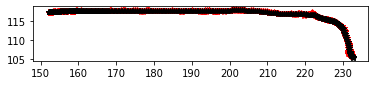

24(1686, 2)
24(284, 2)


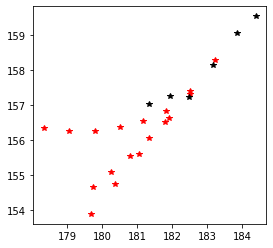

25(18, 2)
25(6, 2)


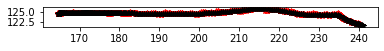

26(1494, 2)
26(252, 2)


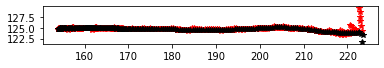

30(1332, 2)
30(225, 2)


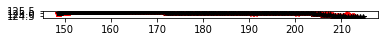

35(1266, 2)
35(214, 2)


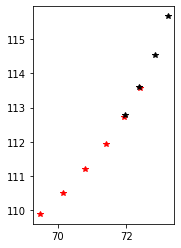

33(6, 2)
33(4, 2)


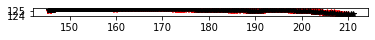

34(1266, 2)
34(214, 2)


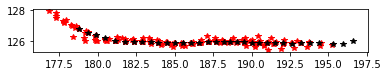

37(180, 2)
37(33, 2)


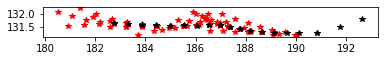

38(96, 2)
38(19, 2)


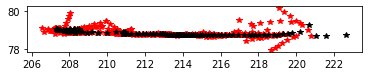

45(588, 2)
45(101, 2)


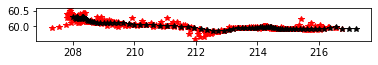

53(474, 2)
53(82, 2)


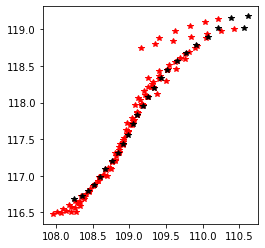

54(132, 2)
54(25, 2)


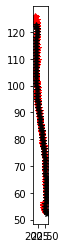

55(378, 2)
55(66, 2)


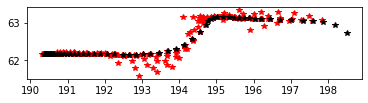

56(348, 2)
56(61, 2)


In [37]:
import matplotlib.pyplot as plt
scene = '1451'
for key in data_argo_6[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_argo_6[scene][key]
  data_gt = data_gt_argo_6[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(str(key) + str(data.shape))
  print(str(key) + str(data_gt.shape))


### Waymo (Done)


In [38]:
print_scene('./data/processed/Waymo/Waymo_0000_full.pkl')

850 Scene: Duration: 19.8s, Nodes: 17, Map: No.
851 Scene: Duration: 19.900000000000002s, Nodes: 1, Map: No.
852 Scene: Duration: 19.900000000000002s, Nodes: 18, Map: No.
853 Scene: Duration: 19.8s, Nodes: 16, Map: No.
854 Scene: Duration: 19.8s, Nodes: 40, Map: No.
855 Scene: Duration: 19.8s, Nodes: 3, Map: No.
856 Scene: Duration: 19.900000000000002s, Nodes: 20, Map: No.
857 Scene: Duration: 19.700000000000003s, Nodes: 13, Map: No.
858 Scene: Duration: 19.900000000000002s, Nodes: 46, Map: No.
859 Scene: Duration: 19.8s, Nodes: 7, Map: No.
860 Scene: Duration: 19.900000000000002s, Nodes: 13, Map: No.
861 Scene: Duration: 19.8s, Nodes: 12, Map: No.
862 Scene: Duration: 19.8s, Nodes: 6, Map: No.
863 Scene: Duration: 19.8s, Nodes: 34, Map: No.
864 Scene: Duration: 19.8s, Nodes: 5, Map: No.
865 Scene: Duration: 19.8s, Nodes: 13, Map: No.
866 Scene: Duration: 19.900000000000002s, Nodes: 1, Map: No.
867 Scene: Duration: 19.900000000000002s, Nodes: 11, Map: No.
868 Scene: Duration: 19.8s, No

In [39]:
data_waymo_2, data_gt_waymo_2 = plot_trajectories('models/int_ee', 12, './data/processed/Waymo/Waymo_0000_full.pkl', 'VEHICLE', 2)

 17%|█▋        | 4/24 [00:00<00:00, 38.58it/s]


Loading from models/int_ee/model_registrar-12.pt
Loaded!

-- Preparing Node Graph


  0%|          | 0/24 [00:00<?, ?it/s]

Prediction Horizon: 2
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 24/24 [01:26<00:00,  3.60s/it]


In [40]:
data_waymo_2.keys()
for key in data_waymo_2.keys():
  print(key + ' ' + str(data_waymo_2[key].keys()))

850 dict_keys(['1', '3', 'ego', '7', '9', '10', '12', '17', '16', '15', '30', '35', '36', '34', '37', '38', '40'])
851 dict_keys(['ego'])
852 dict_keys(['4', 'ego', '9', '10', '11', '13', '12', '15', '14', '16', '17', '21', '22', '20', '19', '18', '23', '24'])
853 dict_keys(['ego', '19', '18', '16', '15', '13', '14', '3', '5', '6', '8', '9', '7', '34', '35', '36'])
854 dict_keys(['24', '25', '26', '27', '28', '29', '30', '31', '33', '23', '37', '38', '40', '41', '42', '44', '45', 'ego', '36', '34', '20', '21', '19', '18', '17', '15', '46', '47', '50', '51', '52', '53', '55', '56', '58', '59', '63', '71', '72', '73'])
855 dict_keys(['ego', '6', '10'])
856 dict_keys(['23', '24', '32', 'ego', '21', '20', '19', '3', '7', '5', '17', '12', '13', '15', '10', '46', '47', '48', '49', '50'])
857 dict_keys(['ego', '19', '18', '11', '10', '21', '22', '23', '27', '26', '40', '41', '43'])
858 dict_keys(['20', '21', '22', '23', '24', '25', '26', '19', '28', '30', '31', '32', '33', '34', '35', 'ego', 

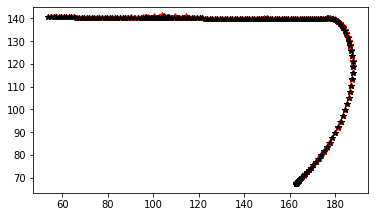

In [41]:
import matplotlib.pyplot as plt
data = data_waymo_2['862']['4']
data_gt = data_gt_waymo_2['862']['4']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()

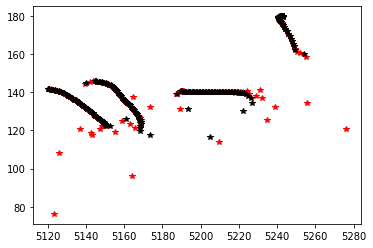

41(392, 2)
41(199, 2)


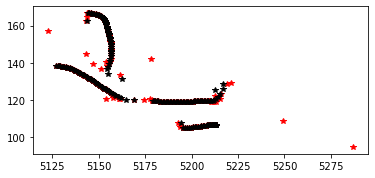

40(392, 2)
40(199, 2)


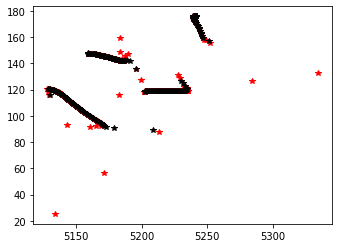

35(392, 2)
35(199, 2)


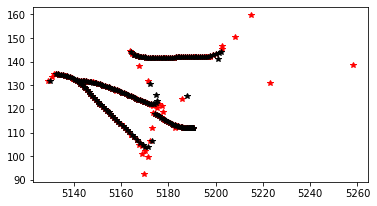

34(392, 2)
34(199, 2)


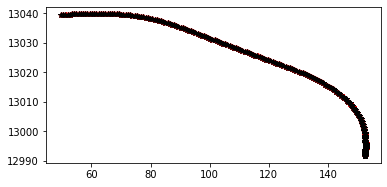

ego(392, 2)
ego(199, 2)


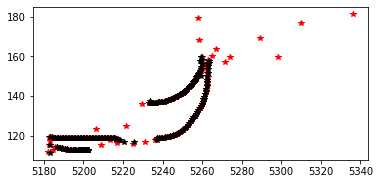

27(392, 2)
27(199, 2)


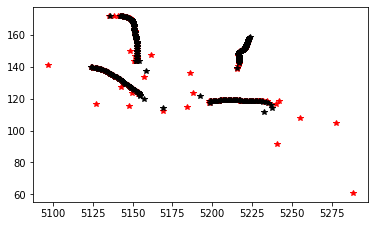

19(392, 2)
19(199, 2)


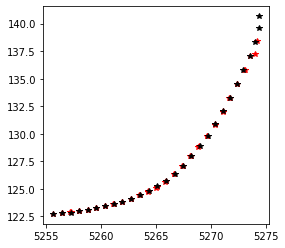

79(50, 2)
79(28, 2)


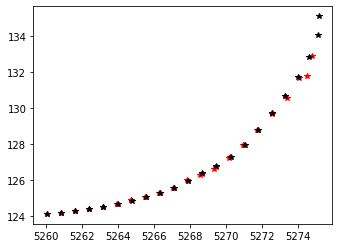

80(38, 2)
80(22, 2)


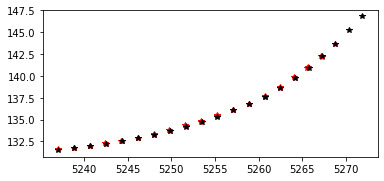

81(36, 2)
81(21, 2)


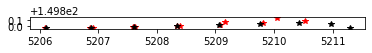

82(12, 2)
82(9, 2)


In [42]:
import matplotlib.pyplot as plt
scene = '867'
for key in data_waymo_2[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_waymo_2[scene][key]
  data_gt = data_gt_waymo_2[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(str(key) + str(data.shape))
  print(str(key) + str(data_gt.shape))


In [43]:
data_waymo_4, data_gt_waymo_4 = plot_trajectories('models/int_ee', 12, './data/processed/Waymo/Waymo_0000_full.pkl', 'VEHICLE', 4)

 17%|█▋        | 4/24 [00:00<00:00, 38.14it/s]


Loading from models/int_ee/model_registrar-12.pt
Loaded!

-- Preparing Node Graph


  0%|          | 0/24 [00:00<?, ?it/s]

Prediction Horizon: 4
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 24/24 [01:26<00:00,  3.62s/it]


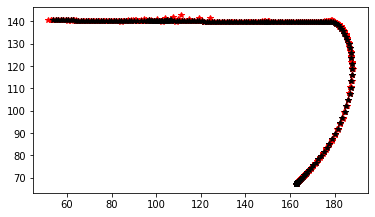

In [44]:
import matplotlib.pyplot as plt
data = data_waymo_4['862']['4']
data_gt = data_gt_waymo_4['862']['4']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()

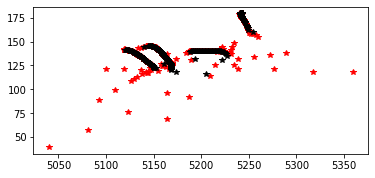

41(784, 2)
41(199, 2)


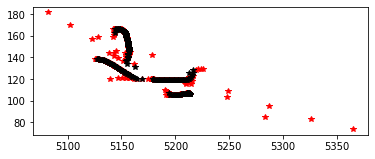

40(784, 2)
40(199, 2)


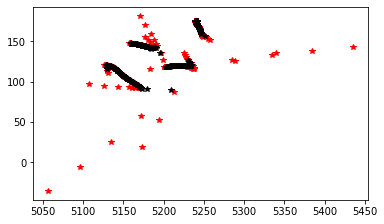

35(784, 2)
35(199, 2)


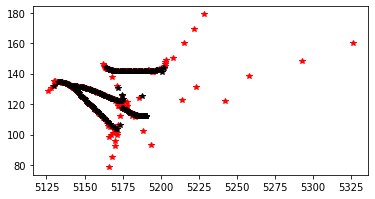

34(784, 2)
34(199, 2)


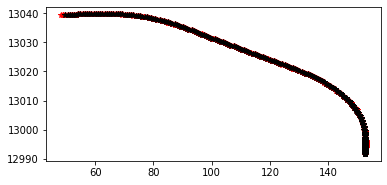

ego(784, 2)
ego(199, 2)


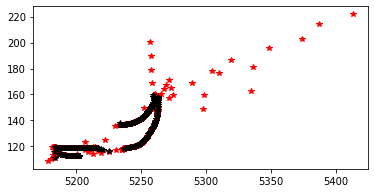

27(784, 2)
27(199, 2)


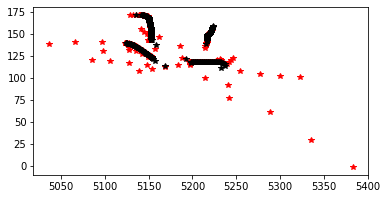

19(784, 2)
19(199, 2)


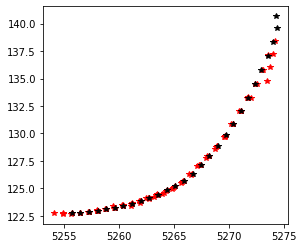

79(100, 2)
79(28, 2)


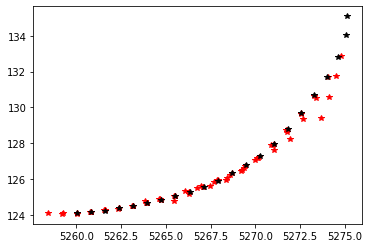

80(76, 2)
80(22, 2)


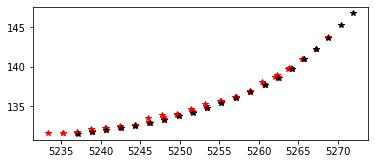

81(72, 2)
81(21, 2)


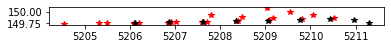

82(24, 2)
82(9, 2)


In [45]:
import matplotlib.pyplot as plt
scene = '867'
for key in data_waymo_4[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_waymo_4[scene][key]
  data_gt = data_gt_waymo_4[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(str(key) + str(data.shape))
  print(str(key) + str(data_gt.shape))


In [46]:
data_waymo_6, data_gt_waymo_6 = plot_trajectories('models/int_ee', 12, './data/processed/Waymo/Waymo_0000_full.pkl', 'VEHICLE', 6)

 17%|█▋        | 4/24 [00:00<00:00, 37.73it/s]


Loading from models/int_ee/model_registrar-12.pt
Loaded!

-- Preparing Node Graph


  0%|          | 0/24 [00:00<?, ?it/s]

Prediction Horizon: 6
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 24/24 [01:27<00:00,  3.65s/it]


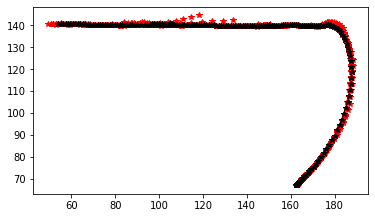

In [47]:
import matplotlib.pyplot as plt
data = data_waymo_6['862']['4']
data_gt = data_gt_waymo_6['862']['4']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()

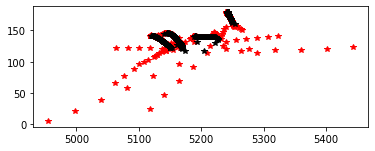

41(1176, 2)
41(199, 2)


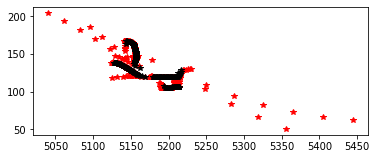

40(1176, 2)
40(199, 2)


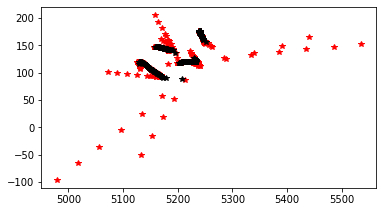

35(1176, 2)
35(199, 2)


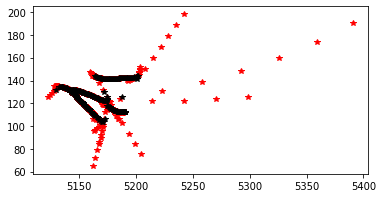

34(1176, 2)
34(199, 2)


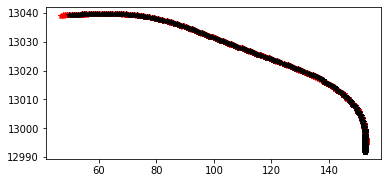

ego(1176, 2)
ego(199, 2)


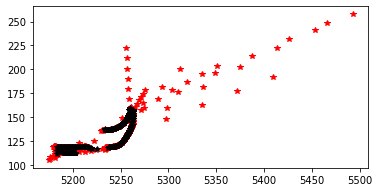

27(1176, 2)
27(199, 2)


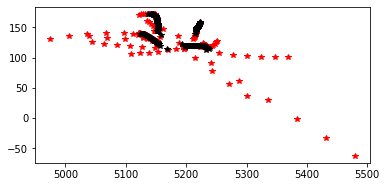

19(1176, 2)
19(199, 2)


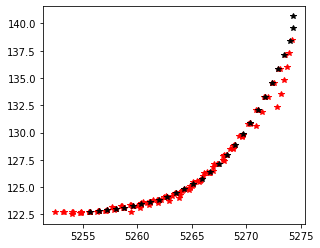

79(150, 2)
79(28, 2)


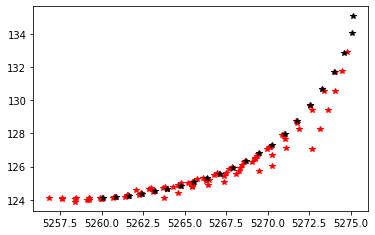

80(114, 2)
80(22, 2)


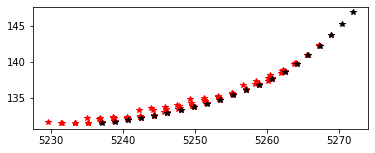

81(108, 2)
81(21, 2)


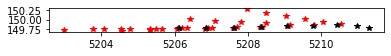

82(36, 2)
82(9, 2)


In [48]:
import matplotlib.pyplot as plt
scene = '867'
for key in data_waymo_6[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_waymo_6[scene][key]
  data_gt = data_gt_waymo_6[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(str(key) + str(data.shape))
  print(str(key) + str(data_gt.shape))
